# Probabilstic Rap Freestyler:  85-426 Final Project 

![title](img/best16.png)

# Abstract

The field of Natural Language Generation has a very wide range of applications for hobbys such as chat-bots, and song or poetry lyric generators. I created a probabilistic model for freestlye rap that is an n-gram model variant and learns from lyrical-data from the discography of specific rap artists.

Most previous attempts to build a program that can generate new rap lyrics have used various types of neural networks Potash 2015, Malmi 2016.
Although neural networks have more more popular language generation, I hypothesized that building a generative rap model with simple maximum likelihood estimation would be a feasible methods of producing impressive results. The limiting factor in most raps is not the lyrical content but the strict rhyme rules that songs must abide by.  Developing a probabilstic model that considers the explicit 

This paper qualitatively demonstrates that the most impressive elements of rap lyric generation from neural networks can be accounted  for the cognitive process of freestyle rap, a simple maximum likelihood evaluation model, a modified version of the typical n-gram model will suffice in the ability to generate meaningful and impressive rap lyrics.  

# Introduction:

Rap is a widely popular genre of music. In many ways, its uniqueness as a genre is defined by the lyrics written by the rappers. 

Freestyle rap is a cognitive process in which rappers spontaneouly come up with meaningful lyrics condensed into lines, (also known as bars). In order for a freestyle to be considered legitament, it's required that these lines not only rhyme together but also make sense together. Freestyling is impressive, because of the amount of rules that a rapper needs to follow in order to sound "fresh".

However, the more someone freestlyes, the easier it is for them to improvise. The limiting factor to one's freestyle ability is usually their "rhyme dictionary", which refers to groups of words that rhyme together.

(A novice rhyme dictionary will include a very limited number of rhymes: cool, school, and pool. 

The rhyme dictionary is important for two reasons: 

1. It allows freestylers with direct access to words that obey the most important rule of rap(rhyming), which otherwise is a very taxing search problem. 

2. Capturing semantic meaning is not only difficult for computers, it is also a very difficult task for rappers who are operating under the very limiting constraints of rhymes. Because of this, words in rhyme dictionaries, automatically determine a meaning for the rapper. 

I was really motivated by the second point. I assumed that as long as I sampled from rhymes that the rapper previously used in songs, there would be enough semantic consistency in order for the newly generated rhyme to make a decent amount of sense. 





In [560]:
import pronouncing as pr
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import *
from random import *
import json

# References

CMU Pronouncing Dictionary at CMU: 
1. http://www.speech.cs.cmu.edu/cgi-bin/cmudict

A simple interface for the CMU pronouncing dictionary:

1. https://github.com/aparrish/pronouncingpy
2. https://pronouncing.readthedocs.io/en/latest/

Rap song writing recurrent neural network trained on Kanye West's entire discography

1. https://github.com/robbiebarrat/rapping-neural-network

Papers:

1. LSTM for Rap Generation - http://www.aclweb.org/anthology/D15-1221
2. Rap Lyric Generator - https://nlp.stanford.edu/courses/cs224n/2009/fp/5.pdf
3. DeepBeat Online Generator - http://www.kdd.org/kdd2016/papers/files/adf0399-malmiA.pdf (half a million lines, applied with RankSVM + Deep Learning)
4. Applying rules structure to aid in freestyle creation (WU 2013) https://aclanthology.info/pdf/D/D13/D13-1011.pdf
5. Using Automated Rhyme Detection to Characterize Rhyming Style in Rap Music (Hirjee Brown 2010) https://kb.osu.edu/dspace/bitstream/handle/1811/48548/EMR000091a-Hirjee_Brown.pdf?sequence=1

RNN v.s. Maximum Likelihood language models (n-gram)

1. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
2. http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139

# CMU rhyming dictionary documentation

Below is some basic commands that were very helpful when designing different functions for my model. It was important to become familiar with the rhyming dictionary so I was aware of my computational constraints.

In [561]:
!grep -C2 NUCLEAR <cmudict-0.7b

DENTZER  D EH1 N T Z ER0
DENUCCI  D IH0 N UW1 CH IY2
DENUCLEARIZATION  D IY0 N UW2 K L IY0 ER2 AH0 Z EY1 SH AH0 N
DENUCLEARIZED  D IH0 N UW1 K L IY0 ER0 AY2 Z D
DENUCLEARIZED(1)  D IY0 N UW1 K L IY0 ER0 AY2 Z D
DENUDE  D IH0 N UW1 D
DENUDED  D IH0 N UW1 D IH0 D
--
--
MONONGAHELA  M AH0 N AO2 NG G AH0 HH EY1 L AH0
MONONOKAI  M AH0 N AA1 N AH0 K AY2
MONONUCLEAR  M AA2 N AH0 N UW1 K L IY0 ER0
MONOPHONIC  M AA2 N AH0 F AA1 N IH0 K
MONOPLANE  M AA1 N AH0 P L EY2 N
--
--
NON-NEMACHER  N AA1 N IH0 M AH0 K ER0
NON-NONSENSE  N AA0 N N AA1 N S EH2 N S
NON-NUCLEAR  N AA1 N UW1 K L IY2 ER0
NON-OPERATING  N AA1 N AO1 P ER0 EY2 T IH0 NG
NON-PACIFIST  N AA2 N P AE1 S IH0 F IH0 S T
--
--
NONNEGOTIABLE  N AA2 N AH0 G OW1 SH AH0 B AH0 L
NONNEMACHER  N AA1 N IH0 M AH0 K ER0
NONNUCLEAR  N AA1 N UW1 K L IY2 ER0
NONOPERATING  N AA1 N AO1 P ER0 EY2 T IH0 NG
NONPACIFIST  N AA2 N P AE1 S IH0 F IH0 S T
--
--
NUCKOLLS  N AH1 K AH0 L Z
NUCKOLS  N AH1 K AH0 L Z
NUCLEAR  N UW1 K L IY0 ER0
NUCLEATION  N UW2 K L IY0 

Basics Functions of the Pronouncing Library

In [562]:
pronunciations = dict()
count = 0
for line in open("cmudict-0.7b", encoding = "ISO-8859-1").readlines():
    line = line.strip()
    if (count == 1000):
        count += 1
    if line.startswith(';'): continue
    word, phones = line.split("  ")
    word = word.rstrip("(0123)").lower()
    if word not in pronunciations:
        pronunciations[word] = []
    pronunciations[word].append(phones)

In [563]:
def count_syllables(phones):
    return sum([phones.count(s) for s in '012'])

In [564]:
def rhyming_part(phones):
    phones_list = phones.split()
    for i in range(len(phones_list)-1, 0, -1):
        if phones_list[i][-1] in '12':
            return ' '.join(phones_list[i:])

## Pronouncing Library in Use

In [565]:
#takes in string (word) and returns syllables
def getSyls(stringWord):
    return pr.syllable_count(pr.phones_for_word(stringWord)[0])

First, we're going to retrieve all of the Kanye West lyrics currently stored in text file

In [566]:
## we need to change all of the words that are buildin' to building'


In [567]:
# Get all Kanye Lyrics 
badWordDict = {'nigga': 'digga', 'bitch':'snitch'}

#takes in a flag that will tell the cleaner whether or not to change the naughty words out for the kids of the USA
#returns a string
def getKanyeText(cleanFlag):
    with open('lyrics.txt') as kanye_lyrics:
        kanyeLyrics = " \n ".join(kanye_lyrics.readlines()[1:])
        print(type(kanyeLyrics))
        kanyeLyrics = kanyeLyrics.lower()
        kanyeLyrics = kanyeLyrics.replace("in'","ing")
        kanyeLyrics = kanyeLyrics.replace("aingt","ain't")
        kanyeLyrics = kanyeLyrics.replace("'til","until")
        kanyeLyrics = kanyeLyrics.replace("'em","them")
        kanyeLyrics = kanyeLyrics.replace("mothafucka","motherfucker")
        kanyeLyrics = ''.join([i for i in kanyeLyrics if not i.isdigit()])
        cleanLyrics = kanyeLyrics
        for cuss in badWordDict:
            cleanLyrics = cleanLyrics.replace(cuss, badWordDict[cuss])
        if (cleanFlag == True):
            kanyeLyrics = cleanLyrics
        return kanyeLyrics
    

kanye_explicit = getKanyeText(False) 
kanye_clean = getKanyeText(True)

<class 'str'>
<class 'str'>


Our **getJsonLyrics()** function is useful because there is a rap api that I was able to query to use all lyrics of any artist. 

This is cool, because artists of the past can essentially be revived in a computational freestyle that should sound similar to previous sound.

In 2012, a hologram of famous rapper, Tupac broke the internet, when it performed alongside Snoop Dogg at Coachella. The video currently has 50 million views. There is clearly public interest in being able to revitalize past rappers in the present. 
(https://www.youtube.com/watch?v=TGbrFmPBV0Y)


In [568]:
def getJsonLyrics(filename, cleanFlag):
    songs = json.load(open(filename))["songs"]
    out = []
    for i in range(len(songs)):
        songLyrics = songs[i]["lyrics"]
        out.append(songLyrics)
    all_lyrics = "\n".join(out)
    kanyeLyrics = all_lyrics.lower()
    kanyeLyrics = kanyeLyrics.replace("in'","ing")
    kanyeLyrics = kanyeLyrics.replace("aingt","ain't")
    kanyeLyrics = kanyeLyrics.replace("'til","until")
    kanyeLyrics = kanyeLyrics.replace("'em","them")
    kanyeLyrics = kanyeLyrics.replace("mothafucka","motherfucker")
    kanyeLyrics = ''.join([i for i in kanyeLyrics if not i.isdigit()])
    cleanLyrics = kanyeLyrics
    for cuss in badWordDict:
        cleanLyrics = cleanLyrics.replace(cuss, badWordDict[cuss])
    if (cleanFlag == True):
        kanyeLyrics = cleanLyrics
    return kanyeLyrics

In [569]:
tupac_explicit = getJsonLyrics('Lyrics_2pac.json', False)
print(type(tupac_explicit))

<class 'str'>


In [570]:
## get all rhyme words

#newList = kanye_explicit.splitlines()
#kanyeLines = [x for x in newList if x != ' ']

In [571]:
kanye_explicit = getKanyeText(False)
kanye_clean = getKanyeText(True)
#wc = WordCloud(width=800,height=400).generate(re.sub(r"\s+"," ", kanye_explicit))
#wc.to_image()

<class 'str'>
<class 'str'>


# The N-gram Model

Before we implement our model, let's review how a basic n-gram model works: a joint probability distribution is calculated for every possible combination of N-characters in a given corpus of text. The joint probability distribution represents all of the possible characters that can follow the corresponding n-character combination.  A sequence of text is created thereafter by first initalizing some n-characters that has a probability distribution and then randomly sampling the next character continuously from the distribution. 

This seems incredibly trivial when compared to how neural networks can learn pattern, but it is very surprising how impressive a simple n-gram model can be at generating random rap lyrics.



In [572]:
def train_char_lm(data, order=4):
    lm = defaultdict(Counter)
    pad = "~" * order
    data = pad + data
    
    for i in range(len(data)-order):
        history, char = data[i:i + order], data[i + order]
        lm[history][char] += 1
        
    def normalize(counter):
        s = float(sum(counter.values()))
        return [(c,cnt/s) for c,cnt in counter.items()]
    outlm = {hist:normalize(chars) for hist, chars in lm.items()}
    return outlm

In [573]:
lm = train_char_lm(kanye_explicit, order=4)

In [574]:
def generate_letter(lm, history, order):
        history = history[-order:]
        dist = lm[history]
        x = random()
        for c,v in dist:
            x = x - v
            if x <= 0: return c

In [575]:
def generate_text(lm, order, nletters=1000):
    history = "~" * order
    out = []
    for i in range(nletters):
        c = generate_letter(lm, history, order)
        history = history[-order:] + c
        out.append(c)
    return "".join(out)

We are going to observe how the n-gram model is able to perform on the kanye west explicit lyrics with an order of 2, 5, and 10 characters while trying to create a sequence of 400 characters. 

In [576]:
orderN = 2
lm = train_char_lm(kanye_explicit, order=orderN)
print(generate_text(lm, orderN, 400))

i he old let thead i a hand it
 pab to i wearld
 thembut the fars
 we at bret s-spen my ands yout? to ockin't a witchitelinnow
 moverealk tallon they que fland fore saybour donever foozerclover con
 i do a cant
 
 
 on g''
 
 all do girl you was night?
 
 the a ne
 
 
 
 
 die st i'vend ainged  this st oh ater leve i wast romand is linget muchaelce i do camend beforlshis
 
 like dring by nowsummy 


Clearly, two characters is not sufficient to even create coherent meaning on the word level. Thus, a greater "n" is needed

In [577]:
orderN = 5
lm = train_char_lm(kanye_explicit, order=orderN)
print(generate_text(lm, orderN, 400))

i threw me you for than that lie
 
 they got the west is bitch, give you
 
 you gon' call out line glass
 
 shut don't control these nigga, i'ma be any hat bad bitches the cca
 
 me a little lotion, lemme they camera
 
 what i love with the can i kill and image, no came ol' two whiter than they couldn't wanna layaway from a travolta
 
 yeezy said shit
 
 
 nothing's
 
 she feeling like shyne with 


The n = 5 model is clearly performing better than the previous model, because actual english words are able to be generated, but by in large the lines do not convey any meaning. 

In [578]:
orderN = 10
lm = train_char_lm(kanye_explicit, order=orderN)

In [579]:
print(generate_text(lm, orderN, 400))

i threw suicides on the private jet
 
 you know what do to with us
 
 in the city, they about to experience will happen
 
 so the king of the damn cake
 
 now that's very un-spike lee
 
 but i feel like i'm sniffing coke
 
 it's a party in your spouse again
 
 black on black is the hate in advance, pull down your pants
 
 i put holes in his face about piranha-sized
 
 that's why i'm
 
 seven o'clo


This is already pretty impressive as a rap model. The simple n-gram exhibits the ability to generate new line. Additionally, the n-gram model is able when to detect when to end a line. This behavior is possible because the new line is detected as the character "\n" in python, so the probability distribution that is learned for every possible combination of n characters will include the newline character as a reasonable succeeding letter wherever it is appropriate. 

This feature that is captured in n-grams, is very helpful for our modeling of rap, because one of the neccessary stylic requirements of rap is the existence of "bars" as independent semantic sequences. While many raps develop meaning by layering bars, there are equally many that are simply tangentially related, but not necessarily completely semantically dependent. Because of this, I thought I could get away with a model 

Still as impressive as this is, it doesn't resemble a rap, because the sentences do not even remotely rhyme with each other. In my model I will present a novel way to enforce a rhyme into each line while just using the N-gram approach.

To drive home the limitations of the n-gram model, let's observe what happens if we set a very high n, n = 25

In [515]:
orderN = 25
lm = train_char_lm(kanye_explicit, order=orderN)
print(generate_text(lm, orderN, 400))

i threw suicides on the tour bus
 
 i threw suicides on the private jet
 
 you know what that mean, i'm fly to death
 
 i step in def jam building like i'm the shit
 
 tell them give me fifty million or i'ma quit
 
 most rappers' taste level ain't at my waist level
 
 i'm fly get on a plane jet lagged already
 
 i'm tired, the goyard bags is heavy
 
 i'm fire, the flow hard as a chevy
 
 i told he


Above you will see that the model essentially directly copies Kanye West's entire verse from the song "Mercy". Since N is set so high, there is likely always going to be only 1 possible character in every probabiity distribution which we are randomly sampling. As a result, the markov chain of characters sampled is reduced simply to the text that the learning model was trained on. 

# Exploratory Data Analysis

Because Rap is rap, I suspected that there would be many words that weren't available in the CMU pronouncing dictionary. This meant that I wasn't going to be able to determine the corresponding rhymes for these specific words.

In [516]:
#now try searching for unidentified words

mystr = kanye_clean
wordList = re.sub("[^\w]", " ",  mystr).split()

unWords = set()
countUnwords = 0 

knwnWords = set()
countKnwnWords = 0

for i in wordList:
    if i not in pronunciations: 
        unWords.add(i)
        countUnwords += 1
    else:
        knwnWords.add(i)
        countKnwnWords += 1
    
print("Number of distinct words recognized by CMU rhyme dict :", len(knwnWords))
print("Number of dictinct words not recognized by CMU rhyme dict :", len(unWords))


print("Times a word is recognized by CMU rhyme dict :", countKnwnWords)
print("Times a word is not recognized by CMU rhyme dict :", countUnwords)

Number of distinct words recognized by CMU rhyme dict : 5159
Number of dictinct words not recognized by CMU rhyme dict : 681
Times a word is recognized by CMU rhyme dict : 52429
Times a word is not recognized by CMU rhyme dict : 1945


As we can see, many of the words will not be detected by the rhyme dictionary. Because this is considerable percentage of the words, it would be impractical to try to remove these words for the training set. Instead, we will only limit the set of rhyming words, which will allow for considerable flexibility within each line of the rap. As a result, I limited the words I would use for rhyming words to just words that could rhyme detect. The unfortunate side effect of this is that there is no straightforward way to calculate the syllables in a given line if one of the words is not available in the rhyming dict.

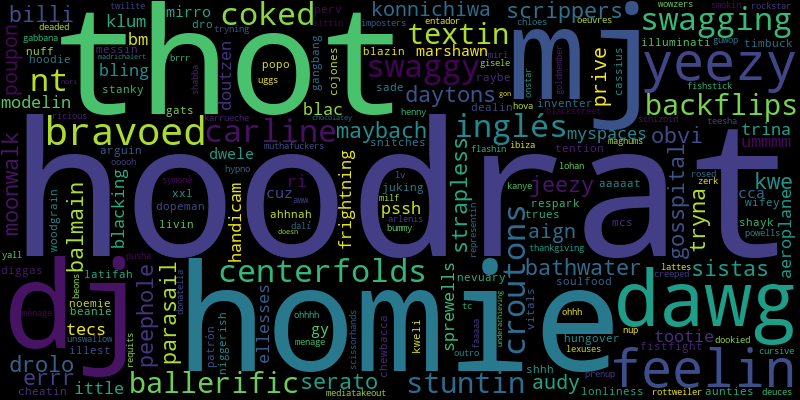

In [517]:
listOfUnknown = list(unWords)
allUnknown = " ".join(listOfUnknown)

wc = WordCloud(width=800,height=400).generate(re.sub(r"\s+"," ", allUnknown))
wc.to_image()

## Specify loose rhymes

Because rappers seldom use strict rhymes in their rhymes I needed to right my own rhyme function that determined if two words "loosely" rhymes, which basically means that they had the same last vowel sound in the two words.

A strict rhyme considers the entirety of the last sound instead of just the vowel part. 

For example:

Gold and Fold strictly rhyme
but Gold and Roll do not.

Meanwhile, 

Gold and Fold and Roll all loosely rhyme. Which is more representative of the threshold of rhyme that will sufficiently connect two bars in a song.

In [518]:
#just checks the vowel sound and stress TODO can modify to account for LESS. AKA dropping the stress
#also checks last letter for sequential lines 

def loose_rhyme(w1, w2):
    phone1 = pr.phones_for_word(w1)[0]
    phone2 = pr.phones_for_word(w2)[0]
    ph1 = re.sub("[^\w]", " ",  phone1).split()
    ph2 = re.sub("[^\w]", " ",  phone2).split()                   
    v1s = [x for x in ph1 if bool(re.search(r'\d', x))][-1]
    v1 = ''.join([i for i in v1s if not i.isdigit()])
    v2s = [x for x in ph2 if bool(re.search(r'\d', x))][-1]
    #remove all numbers so news and parachute rhyme .
    v2 = ''.join([i for i in v2s if not i.isdigit()])                          
    return (v1 == v2 or (w1[-1] == w2[-1]))

In [519]:
#takes in a word and returns the loose rhyme vowel
def getRhymeSyl(w1):
    phone1 = pr.phones_for_word(w1)[0]
    ph1 = re.sub("[^\w]", " ",  phone1).split()                 
    v1s = [x for x in ph1 if bool(re.search(r'\d', x))][-1]                         
    return (v1s)

In [520]:
#takes lyrics and turns into BARS
def getBars(lyrics):
    trainBars = lyrics.splitlines()  
    cleanBars = [x for x in trainBars if x != ' ']
    return cleanBars
    

In [521]:
#takes in list of bars and returns all of the rhyming words
def getRhymes(bars):
    allRhymes = []
    #get all lines from lyrics
    for i in bars:
        tempList = re.sub("[^\w]", " ",  i).split()
        if (len(tempList) > 2):
            allRhymes.append(tempList[-1])       
    return allRhymes
    

In [522]:
def getCountRhymes(rhymez): 
    cat_dict = Counter(rhymez)
    return cat_dict

The creation of a rhyme dictionary was integral to being able to implement a novel n-gram variant for language generation in the context of rap music. 

In [523]:
def createRhymeDict(lyrics):
    allLines = getBars(lyrics)
    allRhymes = getRhymes(allLines)
    allRhymeCount = Counter(allRhymes)
    
    
    rhymeDict = dict()
    
    lastSyl = None
    lastWord = None
    
    for rhymeTup in allRhymeCount.most_common():
        #can use getRhymeSyl and looseRhyme
        rhymeWord = rhymeTup[0]
        if (rhymeWord in pronunciations):
            
            rhySyl = getRhymeSyl(rhymeWord) 
            if rhySyl not in rhymeDict:
                rhymeDict[rhySyl] = list()
            rhymeDict[rhySyl].append(rhymeTup)
            
    return rhymeDict

# Reverse N-gram for "Bar" creation

Rather than creating a probability distribution for the character to succeed a given N characters, my model sampled directly from the distribution of characters that **preceeded** the current n characters under observation. This was a necessary change because in order to create each line based off the rhyming word, we would have to anchor the initial n-characters in the last word of the line and build the markov chain backwards from there.

In [524]:
#takes in a string and order and trains the n-gram model backwards
def train_char_lm_rev(data, order=4):
    lm = defaultdict(Counter)
    pad = "~" * order
    data = pad + data
    
    for i in range(len(data)-order-1):
        history, char = data[i+1: i + order+1], data[i]
        lm[history][char] += 1
        
    def normalize(counter):
        s = float(sum(counter.values()))
        return [(c,cnt/s) for c,cnt in counter.items()]
    
    outlm = {hist:normalize(chars) for hist, chars in lm.items()}
    return outlm

In [525]:
def generate_letter_rev(lm, history, order):
        history = history[:order]
        dist = lm[history]
        x = random()
        for c,v in dist:
            x = x - v
            if (x <= 0): return c

In [526]:
#takes in a string of lyrics and returns the avg # of vowels per line
#is correlated with syllables per line. havne't had time to incororate meter into this model yet
def getNumVow(lyrics):
    newList = lyrics.splitlines()
    kanyeLines = [x for x in newList if x != ' ']
    the_vowels = ["a","e","i","o","u"]
    numLines = len(kanyeLines)
    totalVowels = 0
    for i in kanyeLines:
        for char in i:
            if char in the_vowels:
                totalVowels = totalVowels + 1
    return (totalVowels / numLines)


In [527]:
def getNormedDist(dict1, t_bars):
    
    rhyme_dict = dict1
    all_rhymes = getRhymes(t_bars)
    # creates list of all words that end bars
    

    rhyme_phones = [key for key, val in rhyme_dict.items()]
    #intermediate then generate corresponding distributions
    

    perDict = dict.fromkeys(rhyme_phones, 0)
    for i in (all_rhymes):
        if i in pronunciations:
            key1 = getRhymeSyl(i)
            perDict[key1] += 1
            
    #Prep to normalize all vals by dividing by total
    listOfAllVals = []
    for key1, val1 in perDict.items():
        listOfAllVals.append(val1)
    s = float(sum(listOfAllVals))
    normedPerDict = {rhy_pho : count1/s for rhy_pho, count1 in perDict.items()}
    return normedPerDict    
        
    
    
#    rhyme_pho_weights = [perDict[phone] for phone in rhyme_phones]
    


As mentioned before, each bar is generated completely independently based off of the rhyme that is chosen. While this exposing one main flaw with our design-- that the rhymes shouldn't have to do with each other, we contest that certain rhyme schemes according to each artist will correspond to their own unique subset of semantic meanings.

In [545]:
import random as rd
import string

#change vowelCount to syl count asap
def generate_bar(lm, num_vowel, order, rhyme, rhyme_dict):
    the_vowel = ["a","e","i","o","u"]
    realPunc = [".","?","!","\n"]
    
    listOfAllVals = []
    rhyme_list_tup = rhyme_dict[rhyme]
    
    rhyme_words = []
    rhyme_weights = []


    for (x,y) in rhyme_list_tup:
        rhyme_words.append(x)
        rhyme_weights.append(y)
    
    s = float(sum(rhyme_weights))

    rhyme_pho_weights = [weight/s for weight in rhyme_weights]
    lastWord = np.random.choice(rhyme_words, p=rhyme_pho_weights)
    
    # use regex to find expession in lm dict keys that starts with lastWord and fills 
    # in the remaining (order - len(lastWord)) characters for h
    if (len(lastWord) < order):
        pot_starts = []
        #had to cover beginning edgecase or else the eventual looking up in to lm[history] would 
        #completely break 
        for key, value in lm.items():     # iter on both keys and values
            if key.startswith(lastWord):
                pot_starts.append(key)
        #would rather not make this random. 
        history = rd.choice(pot_starts) 
    else:
        history = lastWord 
    out = []
    out.insert(0, lastWord)
    endlineFlag = True
    rhyme_dict = rhyme_dict
    #hacky solution to syllable counting -> change in future
    vowelCount = 0
    while (endlineFlag):
        c = generate_letter_rev(lm, history, order)
        if (c in the_vowel):
            vowelCount = vowelCount + 1
        history = c + (history[:order])
        if (vowelCount > num_vowel) and (c in realPunc):
            endlineFlag = False
        #extend
        else:
            out.insert(0,c)
    # keep it as one line at least
    out = list(filter(lambda a: a != "\n", out))
    return "".join(out)
        
    

In [550]:
#verse examples is a list of (lists of tuples (syl(vowel), rhyme) )
#I created these examples by manually counting and checking rhymes to ensure accuracy
#v_e[0] = Gold Digger
#v_e[1] =
verseExamples = [["b","b","b","b","c","c","c","c", "c","c","c","c","c"]]

In [551]:
def getRhymeForBar(checkList, letter):
    if letter == "a":
        return checkList[0]
    if letter == "b":
        return checkList[1]
    if letter == "c":
        return checkList[2]
    else:
        return checkList[3]

In [552]:
#main function ties all functions together
# (lyrics : string, order : integer) suggested 12

def generate_verse(lyrics, order):
    num_vow = 4
    #clean text from string, format bars, etc... 
    t_bars = getBars(lyrics)
    verse_skeleton = rd.choice(verseExamples)
    
    lm_rev1 = (train_char_lm_rev(lyrics, order))
    
    #choose the rhyme bars based of a weighted distribution
    rhyme_dict = createRhymeDict(lyrics)
    # creates list of all words that end bars
    rhyme_phones = [key for key, val in rhyme_dict.items()]
    
    normedPerDict = getNormedDist(rhyme_dict, t_bars)
    
    rhyme_pho_weights = [normedPerDict[phone] for phone in rhyme_phones]
    
    
    #generate different rhyme schemes in advance 
    a = np.random.choice(rhyme_phones, p=rhyme_pho_weights)
    b = np.random.choice(rhyme_phones, p=rhyme_pho_weights)
    c = np.random.choice(rhyme_phones, p=rhyme_pho_weights)
    d = np.random.choice(rhyme_phones, p=rhyme_pho_weights)
    checkList = [a,b,c,d]
    
    bars = []
    
    for rhyme_phone3 in verse_skeleton:
        bar_rhyme = getRhymeForBar(checkList, rhyme_phone3) 
        bar = generate_bar(lm_rev1, num_vow, order, bar_rhyme, rhyme_dict)
        bars.append(bar)
    return "\n".join(bars)

The generate verse function call the generate bar function the necessary amount of times in order to create a full verse. 

In [580]:
print(generate_verse(kanye_explicit, 10))

 now everything i want to see thee more clear
 i might rider  but with my brits
 you don't wanna fuck me wit
 i mean i might slam  pink
 got a dark-skinned friend, look like half
 especially in my pastel, i pass
 fired a week later, i'm in the children, listen to the hustlers, gang
 the block with you  but i had
 remember when i walk down that
 these niggas ain't play pause i'm not too laugh
 so many imaginary friend  and  stacks
 cause even if i don't get through yves st. laurent is my past
 feel like?  telling me that


This model clearly outperforms the basic n-gram in being able to produce meaningful lines. Additionally, I would add that this model roughly represents how these artists would freestyle if they had to think of lines on the spot. In freestyling you first establish the sequence of rhymes and then you work backwards in your head so that the line ends up making sense, which is very similar to the sequential nature of this algorithm. Nine was chosen off o

In the future instead of sampling randomly from the distribution of how likely a rhyme is, I would also like to consider how likely a rhyme is, based off of a previous rhyme word. That way there is multiple markov chains of rhymes embedded in every verse. This however, would require a much larger data set than one artist's discography and would have to be part of a different project.

In [555]:
print(generate_verse(kanye_clean, 9))

 how do you rate yourself in a room doing  beats a day for  summers
 so i'mma live like it's all about the precinct  we rappers and managers
 that's right (that's my favorite rapper
 when i pulled up at the oscars
 so many lines, you photograph
 whatever come back when the shit that you play fair? mmmnnnn  grab your kodak
 or rocking the stardom will turn you to a maniac
 ice chain, carti lens, and a knapsack
 and giving head is like a hovercraft
 and bow so hard when it rained  let's play the handyman
 all of which is legal in amsterdam
 or grab your waist then, i'mma grab your waist then, i'mma grab your remote, for the fame, man, that don't play the handyman
 all of which is legal in amsterdam


In [534]:
## TODO =  probabilistically choose the rhymes
## add twitter data
## add syllables into rhyme generation
##  and she grabbed my golf balls

Just for fun, we are going to demonstrate our model trained on two other famous rappers: Biggie and 2Pac.

![title](img/tuBig.png)

In [556]:
tupac_explicit = getJsonLyrics("Lyrics_2pac.json", False)
biggie_explicit = getJsonLyrics("Lyrics_TheNotoriousB.I.G..json", False)

In [543]:
print(generate_verse(biggie_explicit, 9))

another amateur trying to see a nigga, is you dead broke, you would be generous
 two words, i'm gonna make your killings clean, slugs up in between, know what i'm the perfect disciples
a born gangsta hoes kobe bryant scared to sodomizeand
if not, i hope it is but if it's on in the
get your friends beg for ends for me to lendbut this
to all my queensbridge (niggas!)to all my brooklynwith
my dick got rocks in the ashtray, spark this bitch
nigga i toast ya, put fear
playin "love is a house," and thinkin 'bout willis
your little sister, damn i really we be serving
we'll be all fucking you bitches
pull your hail girl, bite cha necklace stripping
but the box, i ain't marching, we shooting
strictly gun testing, coke measuring
everything that forty-five, plotting to portray real but they don't lie to me motherfuckers like mr. fantastic
the cleanest, meanest penis
ice project off lights, chick flashes


In [544]:
print(generate_verse(tupac_explicit, 9))

i want money, hoes and see how good a nigga getting stacks, making legend
god coming, start runningyelling evil
steady thuggin with a passion, forever thugging on my mama
there was no other now them niggas knew, i'm a criminal behaviour- criminal(criminal, criminal
but someone kiss to stitch you
we can do it illegal so the evil man dofaced with you
huggin on a quest to get evicted, can't pay the rent's due
dear lord can you explain to a nigga here, now biggie tell me through my highschool yearboo
passed by his family, of this vest see, so nigga flipping coke in corner store bodegas, in the back room playing with a nigga feel, when i'm standing at a bar full of demons
to the mosque, don't wanna rush ya, but make your life, time to aim trigger for you i wanna know if she gon' set up this plantation
", running all you busta
poverty and frustration, aggravation, temptation
drowned in by screams, no answers to questions
the flower blooms with brilliance
all of that type of environment
and h

# Discussion and Future work

For future work, first I would like to think of an efficient way of capturing the rhythym . Many rap enthusiasts would argue that the "flow" is much more important than lyrics-- especially since the rise of the "[Mumble Rap]"(http://theconversation.com/mumble-rap-cultural-laziness-or-a-true-reflection-of-contemporary-times-85550)" 

Although my reverse n-gram is simpler and more interpretable the neural networks that were implemented to model freestyle rap, some neural networks (Malmi 2016) almost automatically can detect the rhythm in lines. To compensate for this, I would have to hard code this as a rule for each line. 

I also would like to statistically test my assumption that different rhyme schemes tend to cluster around different semantic concepts, which I assumed would help give my model's rap lines some statistically grounded semantic relationship, despite being independently generated.

# Bibliography

1 . Potash, Peter, Alexey Romanov, and Anna Rumshisky. "Ghostwriter: using an LSTM for automatic RAP lyric generation." Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing. 2015.



2 .  Hieu Nguyen, Brian. "Rap lyric generator." (2009).



3 . Malmi, Eric, et al. "Dopelearning: A computational approach to rap lyrics generation." Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. ACM, 2016.



4 . Hirjee, Hussein, and Daniel Brown. "Using automated rhyme detection to characterize rhyming style in rap music." (2010).